# Python and scikit-image for bioimage analysis

Here is a short introduction on how to work with microscopy images with python.

## Loading microscopy images

Images are manipulated as numerical arrays and in `Python`, the N-dimensional array object is provided by `Numpy`.  The goal here is then to be able to generate `Numpy` arrays from your bioimages. The main problem is that every company has their own proprietary file format (Nikon has .nd2, Zeiss has .czi, etc.) and so you need to be able to parse and interpret the file to extract the arrays and the metadata. For that purpose, the mains available software is `Bio-Formats` which is developed by the Open Microscopy Environment (**OME**) consortium.

Here I provide 2 options to work with bioformats and proprietary format:

1. Using a javabridge which will allow you to work with bioformats directly in Python ([click here](https://github.com/bioimage-analysis/load_image_bioformats/blob/master/Example_usage_bioformats.ipynb)).
2. Using the command line (see following instructions).

Note that the first solution is significantly faster. 

### Installation of the Bio-Formats command line tools

(Mac based systems)

Download the [bftools.zip](http://downloads.openmicroscopy.org/latest/bio-formats/artifacts/bftools.zip) from the [Open Microscopy website](http://www.openmicroscopy.org/site/support/bio-formats5.3/users/comlinetools/), unzip it into a new folder (use a memorable name for example bioformat).

Add bftools to your `PATH`:

```bash
cd ~
export PATH=$PATH:~/bioformat/bftools
```
Add the same line to your `.bash_profile` file:

```bash
cd ~
atom .bash_profile
```

### Using the `bfconvert` tool to read and convert the bioimages in Python

To use bftools (and the command line) in python we will use the `subprocess` module as well as the **bfconvert** tools from `bftools`. **bfconvert** command line tool can be used to convert the file between format supported by [Bio-Formats](http://www.openmicroscopy.org/site/support/bio-formats5.3/supported-formats.html).

In [1]:
import subprocess

input_image = "/Users/Espenel/Desktop/1.czi"
output_image = "output_image.tiff"
image =  ['bfconvert', "-overwrite", "-nolookup", input_image, output_image]
p = subprocess.run(image, stdout=subprocess.PIPE)

I can then read the image using the `io` module from `scikit-image` and plot it using `matplotlib`:

In [2]:
from skimage import io
img = io.imread(output_image)

In [3]:
img.shape

(1, 1, 1960, 1960, 3)

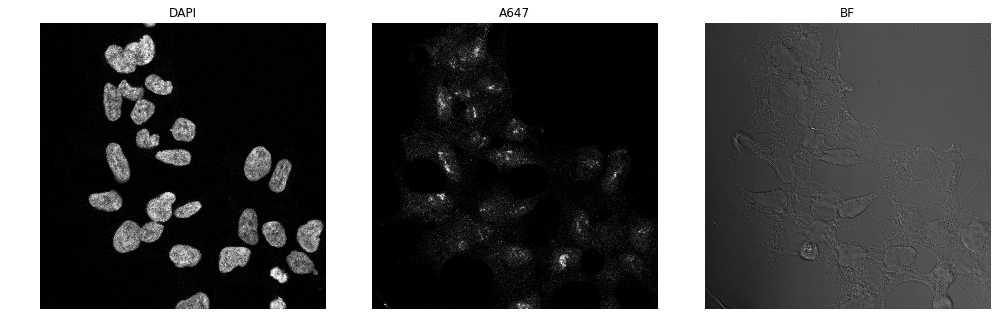

In [4]:
% matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(14, 7))

ax[0].imshow(img[0,0,:,:,0], cmap=plt.cm.gray)
ax[0].set_title("DAPI")
ax[0].set_axis_off()

ax[1].imshow(img[0,0,:,:,1], cmap=plt.cm.gray)
ax[1].set_title("A647")
ax[1].set_axis_off()

ax[2].imshow(img[0,0,:,:,2], cmap=plt.cm.gray)
ax[2].set_title("BF")
ax[2].set_axis_off()

fig.tight_layout()

### Using the `showinf` tool to read the metadata of the bioimages in Python

We will still use the `subprocess` module but this time using the **showinf** tools from `bftools`. **showinf** can be use to display an image as well as the metadata, we will only use to extract the metadata and create a dictionnary with what we want:

In [5]:
inf = ['showinf', "-nopix", "-omexml-only", input_image]

p = subprocess.Popen(inf, stdout=subprocess.PIPE)
stdout = p.communicate()[0]
print('First 500 Characters of STDOUT:\n\n{}'.format(stdout)[:500])

First 500 Characters of STDOUT:

b'<?xml version="1.0" encoding="UTF-8"?>\n<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">\n   <Experimenter ID="Experimenter:0" UserName="LSM User"/>\n   <Instrument ID="Instrument:0">\n      <Microscope/>\n      <Detector AmplificationGain="1.0" Gain="670.0" ID="Dete


I have basically create a string from the stdout or "standard out". I can then convert the stout into an XML string by using the `lxml` module:

In [6]:
import lxml.etree as etree

parser = etree.XMLParser(recover=True)
tree   = etree.fromstring(stdout, parser)

The tree object contains a rooted tree with all our metadata. Each node has a tag, attributes, and children.

In [7]:
for child in tree:
    print(child.tag)

{http://www.openmicroscopy.org/Schemas/OME/2016-06}Experimenter
{http://www.openmicroscopy.org/Schemas/OME/2016-06}Instrument
{http://www.openmicroscopy.org/Schemas/OME/2016-06}Image
{http://www.openmicroscopy.org/Schemas/OME/2016-06}StructuredAnnotations


In [8]:
for child in tree:
    if child.tag.endswith('Image'):  
        for grandchild in child:
            print(grandchild.attrib)  

{'ID': 'Experimenter:0'}
{'ID': 'Instrument:0'}
{'RefractiveIndex': '1.518', 'Medium': 'Oil', 'ID': 'Objective:0'}
{'Interleaved': 'false', 'SizeT': '1', 'BigEndian': 'false', 'PhysicalSizeY': '0.06885262532803958', 'ID': 'Pixels:0', 'SizeC': '3', 'PhysicalSizeX': '0.06885262532803958', 'SignificantBits': '16', 'SizeY': '1960', 'PhysicalSizeXUnit': 'µm', 'PhysicalSizeYUnit': 'µm', 'SizeX': '1960', 'Type': 'uint16', 'SizeZ': '1', 'DimensionOrder': 'XYCZT'}


You can then fetch out the information you need and create a dictionarry with your metadata:

In [9]:
for child in tree:
    if child.tag.endswith('Image'):
        for grandchild in child:
            if grandchild.tag.endswith('Pixels'):
                att = grandchild.attrib
                PhysicalSizeX = (round(float(att['PhysicalSizeX']), 2))
                PhysicalSizeYUnit = att['PhysicalSizeYUnit']
                SizeX = att['SizeX']
                SizeY = att['SizeY']
                SizeC = att['SizeC']
                SizeZ = att['SizeZ']
                SizeT = att['SizeT']
    elif child.tag.endswith('Instrument'):  
        for grandchild in child:
            if grandchild.tag.endswith('Objective'):
                att = grandchild.attrib
                Obj = att['Model']

In [10]:
dic = {
        'PhysicalSizeX' : PhysicalSizeX,
        'PhysicalSizeYUnit' : PhysicalSizeYUnit,
        'SizeX' : SizeX,
        'SizeY' : SizeY,
        'SizeC' : SizeC,
        'SizeZ' : SizeZ,
        'SizeT' : SizeT,
        'Obj' : Obj  
       }

In [11]:
dic

{'Obj': 'Plan-Apochromat 63x/1.4 Oil DIC M27',
 'PhysicalSizeX': 0.07,
 'PhysicalSizeYUnit': 'µm',
 'SizeC': '3',
 'SizeT': '1',
 'SizeX': '1960',
 'SizeY': '1960',
 'SizeZ': '1'}